Best result in current iteration 21.294389182817355 compared to overall 21.294389182817355
Best result in current iteration 21.294389182817355 compared to overall 21.294389182817355
Best result in current iteration 23.488593610491918 compared to overall 23.488593610491918
Best result in current iteration 23.488593610491918 compared to overall 23.488593610491918
Best result in current iteration 25.114499546345886 compared to overall 25.114499546345886
Best result in current iteration 25.114499546345886 compared to overall 25.114499546345886
Best result in current iteration 25.114499546345886 compared to overall 25.114499546345886
Best result in current iteration 25.114499546345886 compared to overall 25.114499546345886
Best result in current iteration 26.41289802410861 compared to overall 26.41289802410861
Best result in current iteration 26.41289802410861 compared to overall 26.41289802410861
Best result in current iteration 31.420811794473853 compared to overall 31.420811794473853
Bes

Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978
Best result in current iteration 105.52611237897978 compared to overall 105.52611237897978

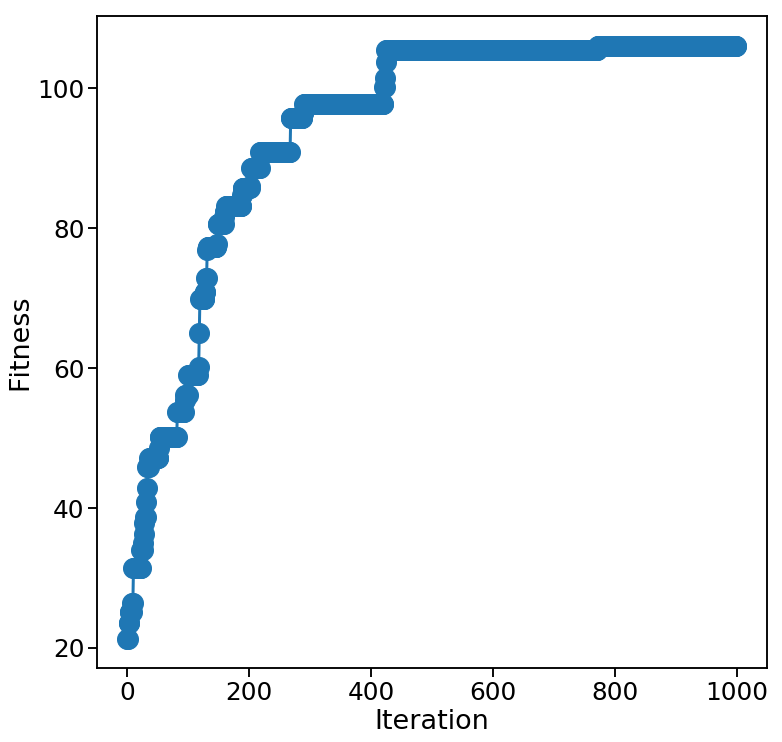

In [1]:

import numpy as np

class GAlgClass(object):
    def __init__(self, weights, round_int):
        self.POP_SIZE = 10
        self.WEIGHTS = weights
        self.N_WEIGHTS = len(weights)
        self.N_MATING = 4
        self.N_OFFSPRING = 3
        self.IDX_CROSSOVER = 3
        # Helper variable that generates POP_SIZE x NUM_WEIGHTS population
        self.DOFS_IN_POP = (self.POP_SIZE, self.N_WEIGHTS)
        self.PM = .5
        self.ROUND_INT = round_int
        
        self.MIN = -4
        self.MAX = 4
    

    # Do some Ipython black magic
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"



    def calc_fitness(self, t_pop):
        """ Calculates fitness given the population using global weights
        The fitness function calulates the sum of products between each input and its corresponding weight.
        Returns a (POP_SIZE, ) numpy array
        """        
        # Do elementwise across columns, then sum the columns up together
        # fitness = np.sum(t_pop * WEIGHTS, axis=1)

        # Do a matrix vector multiply of (10,6) * (6,)
        fitness = t_pop @ self.WEIGHTS

        # There are other ways to do the same thing, but why would you?
        return fitness


    def select_determinstic(self, t_pop, t_fitness):
        """ Given current population t_pop, select N_MATING number of parents using determinstic selection scheme
        based on t_fitness 

        Returns parents and their fitness (just because)
        """
        # Returns sorting indices, based on max fitness
        # Arranged from min-> max fitness
        idx = np.argsort(t_fitness)
        # Now its max fitness on top and min on bottom
        idx = idx[::-1]

        # Sort parents according to the index
        parents = t_pop[idx]

        # Select best parents
        parents = parents[:self.N_MATING, :]
        return (parents, self.calc_fitness(parents))


    def select_stochastic(self, t_pop, t_fitness):
        """ Given current population t_pop, select N_MATING number of parents using SUS
        based on t_fitness 

        Returns parents and their fitness (just because)
        """

        ''' Sampling rate assignment using linear rank-based sampling
        '''
        # Rank based on max fitness
        # Arranged from min-> max fitness
        # Do the same for parents later on
        idx = np.argsort(t_fitness)

        # Copied shamelessly from https://stackoverflow.com/a/5284703
        r_i = np.empty_like(idx)
        r_i[idx] = np.arange(len(t_fitness))

        # Same as 
        # r_i = np.argsort(idx)

        """
            >>> t_fitness
            >>> array([-18.29817097,  22.688013  ,  65.55614464, -22.39372802,
               -11.53236791,  40.55497738, -13.77672983,  14.9189356 ,
                60.09509336,  32.67900684])

            >>> idx
            >>> [3 0 6 4 7 1 9 5 8 2]

            >>> r_i
            >>> [1 5 9 0 3 7 2 4 8 6]
        """

        # Calculate linear weighting with alpha = 2
        p_i = r_i + 2

        # Calculate q_i as an avverage measure of p_i
        sum_pi = np.sum(p_i)
        q_i = p_i / sum_pi

        # Rank from biggest to least for ease of use
        q_idx = np.argsort(q_i)

        # Regular q_i is for t_pop
        # The sorted q_i is now for (t_pop)[q_idx]
        # The reversed q_i is then for ((t_pop)[q_idx])[::-1]

        q_i = q_i[q_idx]
        q_i = q_i[::-1]


        ''' With this sampling rate q_i pick up four parents
        '''
        # Increment to generated random number
        random_increment = 1./self.N_MATING

        # Generate a random number
        random_val = np.random.rand(1, )

        # Select four zones of q_i to select
        arrow_locations = random_val + random_increment * np.arange(self.N_MATING)


        # Ensure it stays within 1
        arrow_locations %= 1


        # In place sorting to get (r, r+1/N_MATING, r + 2/N_MATING ...., r + (N_MATING-1)/N_MATING)
        arrow_locations.sort()


        # Based on arrow locations, pick the parents
        cum_qi = np.cumsum(q_i)


        # Where do you find the arrows within cum_qi
        zone_belong = np.searchsorted(cum_qi, arrow_locations)
        # print(zone_belong)


        # zone_belong returns index of individuals in the max-->min list 
        # I want indices in the min--> max list
        # One hacky way of doing this is just do a size-1 subtraction
        zone_belong = self.POP_SIZE - zone_belong - 1

        # The q_i of the selected indviduals
        parents = t_pop[q_idx][zone_belong]
        par_fitness = t_fitness[q_idx][zone_belong]

        return (parents, par_fitness)


    def crossover(self, t_parents):
        """ Given a set of parents, combine them and return offspring vectors

        Returns the offsprings and their fitness
        """

        # Create an emppty vector
        offspring = np.empty((self.N_OFFSPRING, self.N_WEIGHTS))

        for k in range(self.N_OFFSPRING):
            # We do % N_MATING in case it goes out of range

            # Index of the first parent to mate.
            p1_idx = k%(self.N_MATING)

            # Index of the second parent to mate.
            p2_idx = (k+1)%(self.N_MATING)

            # The new offspring will have its first half of its genes taken from the first parent.
            offspring[k, :self.IDX_CROSSOVER] = t_parents[p1_idx, :self.IDX_CROSSOVER]

            # The new offspring will have its second half of its genes taken from the second parent.
            offspring[k, self.IDX_CROSSOVER:] = t_parents[p2_idx, self.IDX_CROSSOVER:]

        return (offspring, self.calc_fitness(offspring))


    
    def mutation(self, t_offspring):
        """ Given a set of offsprings, introduce mutation in them

        Returns the mutated offsprings and their fitness
        """

        # Mutation changes all genes in each offspring randomly.
        # You can also code for a single gene, single gene with some probability and so on...

        # Generate a random number in [0, 1) to mutate each offspring
        random_mutator = np.random.uniform(0.0, 1.0, (self.N_OFFSPRING,))

        # Check where the random_mutator is > PM
        # Gives true in those places
        idx = random_mutator > self.PM

        # Count number of trues in the above condition
        nnz = np.count_nonzero(idx)

        # Copy just for comparison of offspring before and after mutation
        # You can remove if efficiency is a concern
        mutated_offspring = t_offspring.copy()

        # For true idx, add randomly sampled vector in [-0.5, 0.5)
        # print(random_mutator, idx)
        mutated_offspring[idx] += np.random.uniform(-0.5, 0.5, (nnz, self.N_WEIGHTS))
        
        if self.ROUND_INT:
            mutated_offspring = np.rint(mutated_offspring)

        return (mutated_offspring, self.calc_fitness(mutated_offspring))

    # # Environmental selection
    # The final step is environmental selection. This comes in two parts:
    # 
    # 1) Imposing any hard constraints, such as those violating range being chucked out
    # 
    # 2) Picking the `POP_SIZE` best individuals and sending them to the next generation
    # 
    # Let's first throw out any individuals not adhering to the limits set by or constraints
    def hard_constraint(self, t_total_pop):
        """ Scans the array for individual violating constraint bounds
        and chucks them out of processing

        t_all includes all vectors (parents + mutated offsprings)
        """
        idx1 = (t_total_pop >= self.MIN)
        idx2 = (t_total_pop <= self.MAX)

        # And condition as both must be satisfied
        idx = idx1 & idx2

        # Returns an entire row as false even if one evaluares to False
        # The axis argument tells along which axis it should scan
        idx = np.all(idx, axis=1)

        return t_total_pop[idx]
    

    def environmental_selection(self, t_total_pop):
        """ Calculate total population (after constraint checking) fitness,
        rank accoridingly and select only the top POP_SIZE individuals to
        pass on to the next generation
        """ 

        tot_fitness = self.calc_fitness(t_total_pop)

        # Calculate elements from small->top fitness
        idx = np.argsort(tot_fitness)

        # Reverse to give top->small fitness
        idx = idx[::-1]

        # Cut off POP_SIZE elements
        idx = idx[:self.POP_SIZE]

        # Return corresponding population
        return t_total_pop[idx]
    

    def graphPlot(self):

        curr_population = np.random.uniform(low=self.MIN, high=self.MAX, size=self.DOFS_IN_POP)
        if self.ROUND_INT:
            curr_population = np.rint(curr_population)
        

        my_fitness = self.calc_fitness(curr_population)

        my_parents, my_parents_fit = self.select_determinstic(curr_population, my_fitness)

        my_offspring,  my_offspring_fitness = self.crossover(my_parents)

        my_parents, my_par_fitness = self.select_stochastic(curr_population, my_fitness)

        my_mut_offspring, my_mut_offspring_fitness = self.mutation(my_offspring)

        total_population = np.vstack((curr_population, my_mut_offspring))

        total_population = self.hard_constraint(total_population)
        
        new_population = self.environmental_selection(total_population)

        best_outputs = []
        num_generations = 1000
        curr_population = np.random.uniform(low=self.MIN, high=self.MAX, size=self.DOFS_IN_POP)
        if self.ROUND_INT:
            curr_population = np.rint(curr_population)
        overall_max_fitness = -99999

        # Run many iterations
        # You should also have another convergence check
        for generation in range(num_generations):
            #print("Generation : ", generation)

            # Measuring the fitness of each chromosome in the population.
            fitness = self.calc_fitness(curr_population)

            max_fitness = np.max(fitness)

            # The best result in the current iteration.
            print("Best result in current iteration {0} compared to overall {1}".format(max_fitness, max(max_fitness, overall_max_fitness)))
            best_outputs.append(max_fitness)

            # Selecting the best parents in the population for mating.
            parents, _ = self.select_determinstic(curr_population, fitness)

            # Generating next generation using crossover.
            offspring_crossed, _ = self.crossover(parents)

            # Adding some variations to the offspring using mutation.
            offspring_mutated, _ = self.mutation(offspring_crossed)

            # Check for constraints
            total_population = np.vstack((curr_population, offspring_mutated))
            total_population = self.hard_constraint(total_population)

            # Environmental selection
            curr_population = self.environmental_selection(total_population)

        # Getting the best solution after iterating finishing all generations.
        #At first, the fitness is calculated for each solution in the final generation.
        fitness = self.calc_fitness(curr_population)

        # Then return the index of that solution corresponding to the best fitness.
        max_idx = np.argmax(fitness)
        print("Best solution : ", new_population[max_idx, :])
        print("Best solution fitness : ", fitness[max_idx])
        import pylab as plt
        import seaborn as sns

        sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

        get_ipython().run_line_magic('matplotlib', 'inline')
        plt.figure(figsize=(12,12))
        plt.plot(best_outputs,'-o', lw=3, ms=20, label='from scratch')
        plt.xlabel("Iteration")
        plt.ylabel("Fitness")
        plt.show()
        
        
class Knapsack(GAlgClass):
    def __init__(self, item_values, round_int, num_items, bag, item_weights):
        super().__init__(item_values, True)
        self.MAX = 1
        self.MIN = 0
        self.NUM_ITEMS = num_items
        self.BAG_CAPACITY = bag

        self.ITEM_WEIGHTS = item_weights
        
    def calc_fitness(self, t_pop):

        fitness = t_pop @ self.WEIGHTS
        for i in range(0,len(t_pop)):
            totalWeight = 0
            for k in range(0,len(t_pop[i])):
                totalWeight += t_pop[i][k]*self.ITEM_WEIGHTS[k]
                if totalWeight> self.BAG_CAPACITY:
                    fitness[i] = 0
        return fitness
    def mutation(self, t_offspring):

        random_mutator = np.random.uniform(0.0, 1.0, (self.DOFS_IN_POP))
        for i in range(0,len(t_offspring)):
            for k in range(len(t_offspring[i])):
                if(random_mutator[i][k]>=self.PM):
                    t_offspring[i][k] = (t_offspring[i][k]+1)%2
        mutated_offspring = t_offspring.copy()

        if self.ROUND_INT:
            mutated_offspring = np.rint(mutated_offspring)

        return (mutated_offspring, self.calc_fitness(mutated_offspring))

class Parabola(GAlgClass):
    def __init__(self,n):
        
        weights = np.full((n,),1)
        super().__init__(weights, False)
        self.MIN = -5000
        self.MAX= 5000
        

    def calc_fitness(self, t_pop):

        fitness = t_pop @ self.WEIGHTS
        for i in range(0,len(fitness)):
            fitness[i] = (fitness[i]*fitness[i])*-10

        return fitness
    def crossover(self, t_parents):

        # Create an emppty vector
        offspring = np.empty((self.N_OFFSPRING, self.N_WEIGHTS))

        for k in range(self.N_OFFSPRING):
            # We do % N_MATING in case it goes out of range

            # Index of the first parent to mate.
            p1_idx = k%(self.N_MATING)

            # Index of the second parent to mate.
            p2_idx = (k+1)%(self.N_MATING)

            # The new offspring will have its first half of its genes taken from the first parent.
            offspring[k] = t_parents[p1_idx] * t_parents[p2_idx]/2

        return (offspring, self.calc_fitness(offspring))
    def mutation(self, t_offspring):

        random_mutator = np.random.uniform(low=0.0, high=1.0, size =len(t_offspring))
        self.PM=1
        for i in range(0,len(t_offspring)):
            for k in range(len(t_offspring[i])):
                if(random_mutator[i]<=self.PM):
                    t_offspring[i][k] *= random_mutator[i]
        mutated_offspring = t_offspring.copy()

        return (mutated_offspring, self.calc_fitness(mutated_offspring))
    
class HyperEllipsoid(Parabola):
    def __init__(self):
        super().__init__(2)
    def calc_fitness(self, t_pop):

        fitness = np.empty(len(t_pop),)
        for i in range(0,len(fitness)):
            x = t_pop[i][0]
            x2 = t_pop[i][1]
            fitness[i] = -((np.sqrt(3)/5*(x-3) + .5*(x2-5))**2 + 5*(np.sqrt(3)/5*(x-3) + .5*(x2-5))**2)

        return fitness

    
def main():
    WEIGHTS = np.array([6,8,-6,3,3,-4], dtype = np.float64) # Optional dtype argument
    #__init__(self, pop_size, weights, n_mating, n_offspring, idx_crossover, pm):
    gAlg = GAlgClass(WEIGHTS, False)
    gAlg.graphPlot()
    
def main2():
    # Load data from txt file
    my_data = np.load('A.npz')
    # Data stored as a dictionary
    # use data however you want
    bag = my_data['capacity'] # 20
    num_items = my_data['n_items'] # 50
    item_values = my_data['item_values']
    item_weights = my_data['item_weights']

    
    s = Knapsack(item_values, True,num_items, bag,item_weights )
    s.graphPlot()
    
def main3():
    p = Parabola(1)
    p.graphPlot()

    
    
main()
